# Face Recognition

## Task 1 (30% points): build a neural network for faces classification as discribed above.

### Dataset 

We will train out face recognition network on part of the [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). But we'll use a version of it that has all the images in it aligned and cropped. You can download the dataset using this link: https://disk.yandex.ru/d/S8f03spLIA1wrw

- celebA_imgs — folder with aligned images 
- celebA_anno.txt — file with annotations: which person each image corresponds to
- celebA_train_split.txt — file with train/val/test info

In [1]:
!pip install facenet_pytorch
!pip install imutils
!pip install dlib
!pip install faiss-gpu

     |████████████████████████████████| 1.9 MB 4.3 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=32d65c26704e291d83ff7f3cf1426da8d701f6f080c97de7995b1e857f64dd9c
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils
     |████████████████████████████████| 85.5 MB 73.3 MB/s            


In [2]:
import cv2
from cv2 import imread
from cv2 import imshow
from cv2 import waitKey
from cv2 import destroyAllWindows
from cv2 import CascadeClassifier
from cv2 import rectangle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
import copy
import math
import seaborn as sns
import faiss

import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torch.optim import lr_scheduler
from facenet_pytorch import MTCNN, InceptionResnetV1, training

from PIL import Image, ImageDraw
from IPython import display
from tqdm.notebook import tqdm
from collections import defaultdict
from sklearn.neighbors import KNeighborsClassifier
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import io, transform


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
def detectFace(img):
    opencv_image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR) 
    faces = face_detector.detectMultiScale(opencv_image, 1.3, 5)

    if len(faces) > 0:
        face = faces[0]
        face_x, face_y, face_w, face_h = face
        opencv_image = opencv_image[int(face_y):int(face_y+face_h), int(face_x):int(face_x+face_w)]

        color_coverted = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(color_coverted)
        return pil_image
    
    return img

opencv_home = cv2.__file__
folders = opencv_home.split(os.path.sep)[0:-1]

path = folders[0]
for folder in folders[1:]:
    path = path + "/" + folder

face_detector_path = path+"/data/haarcascade_frontalface_default.xml"

if os.path.isfile(face_detector_path) != True:
    raise ValueError("Confirm that opencv is installed on your environment! Expected path ",detector_path," violated.")

face_detector = cv2.CascadeClassifier(face_detector_path)

# mtcnn = MTCNN(keep_all=True)
# def detectFace(img):
#     opencv_image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR) 
#     boxes, _, = mtcnn.detect(opencv_image, landmarks=False)
#     if boxes is not None:
#         x = int(boxes[0][0])
#         y = int(boxes[0][1])
#         w = int(boxes[0][2])
#         h = int(boxes[0][3])
#         roi_face = opencv_image[y:h,  x:w]
#         color_coverted = cv2.cvtColor(roi_face, cv2.COLOR_BGR2RGB)
#         pil_image = Image.fromarray(color_coverted)
#         return pil_image
#     return img


Example of batch image

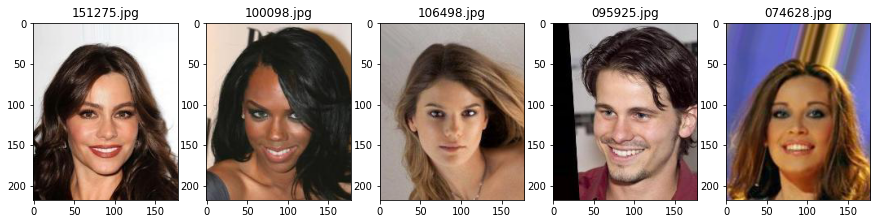

In [5]:
def show_imgs(images_names):
    imgs = []
    for img in images_names:
      img = Image.open(os.path.join('../input/celeba-1k-classes/celebA_train_1k/celebA_imgs', img))
      imgs.append(np.array(img))

    f, axes= plt.subplots(1, len(imgs), figsize=(3*len(imgs),5))
    for i, axis in enumerate(axes):
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].set_title(images_names[i])
    plt.show()

images_names = os.listdir('../input/celeba-1k-classes/celebA_train_1k/celebA_imgs')[20:25]
show_imgs(images_names)

### Train Neural Network

Let's build a Datasets and network using this images:

In [6]:
def get_paths(dataset_type='train'):
    '''
    a function that returnes list of images paths for a given type of the dataset
    params:
      dataset_type: one of 'train', 'val', 'test'
    '''

    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }

    f = open('../input/celeba-1k-classes/celebA_train_1k/celebA_train_split.txt', 'r')
    lines = f.readlines()
    f.close()

    lines = [x.strip().split() for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:            
        images_paths.append(os.path.join('../input/celeba-1k-classes/celebA_train_1k/celebA_imgs', filename))
    
    return np.array(images_paths)


class celebADataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, dataset_type, transform, aug=None,):
        self.images = get_paths(dataset_type=dataset_type)

        f = open('../input/celeba-1k-classes/celebA_train_1k/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:y for x, y in labels}
        self.labels = [int(labels[x.split('/')[-1]]) for x in self.images]

        self.transform = transform
        self.aug = aug
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        img_name = self.images[idx]
        label = self.labels[idx]
        
        image = Image.open(img_name)
        
        # detecting faces
        image_face = detectFace(image)
        
        if self.aug:
            sample = self.aug(
                image=image_face,
            )
        else:
            sample = {
                'image': image_face,
                'label': label,
            }
        
        sample['image'] = self.transform(sample['image'])

        return sample

In [7]:
image_size = (160, 160)
batch_size = 64

transform_train = transforms.Compose([
        transforms.Resize(image_size),
        # transforms.RandomVerticalFlip(p=0.2),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.4),
#         transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))], p=0.4),
#         transforms.CenterCrop(image_size),
        transforms.RandomRotation(10, expand=False, center=None),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_test = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_data = celebADataset('train', transform_train)
val_data = celebADataset('val', transform_test)
test_data = celebADataset('test', transform_test)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [8]:
def train(model, optimizer, criterion, n_epochs, train_loader, val_loader):
    valid_loss_min = np.Inf # track change in validation loss
    for epoch in range(1, n_epochs+1):
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        model.train()
        for batch in tqdm(train_loader):
            image, label = batch['image'].to(device), torch.as_tensor(batch['label']).to(device)
            optimizer.zero_grad()
            output = model(image)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*image.size(0)

        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_loader):
                image, label = batch['image'].to(device), torch.as_tensor(batch['label']).to(device)
                output = model(image)
                loss = criterion(output, label)
                valid_loss += loss.item()*image.size(0)

        # calculate average losses
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(val_loader.sampler)
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_best_weights.pt')
            valid_loss_min = valid_loss

We'll use pretrained on VGGFace2 network InceptionResnetV1 from here: https://github.com/timesler/facenet-pytorch/tree/master/models

In [9]:
model = InceptionResnetV1(pretrained='vggface2', num_classes=1000, classify=True).to(device)

  0%|          | 0.00/107M [00:00<?, ?B/s]

**Workflow**: fine-tune a model on train_data using val_data for validation.Use standard CE loss.  Calculate the loss and accuracy on test set after training. 

You may use any optimizer you want and any learning rate. It is also beneficial to freeze starting layers to boost training speed and avoid overfitting. 

**To get the whole mark for this section you need to achieve 80% accuracy on test set**.

In [10]:
# freeze all layers except the last
for param in model.parameters():
    param.requires_grad = False

for param in model.logits.parameters():
    param.requires_grad = True

for param in model.last_bn.parameters():
    param.requires_grad = True

for param in model.last_linear.parameters():
    param.requires_grad = True

for param in model.block8.parameters():
    param.requires_grad = True

# check which layers requires_grad
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

block8.branch0.conv.weight
block8.branch0.bn.weight
block8.branch0.bn.bias
block8.branch1.0.conv.weight
block8.branch1.0.bn.weight
block8.branch1.0.bn.bias
block8.branch1.1.conv.weight
block8.branch1.1.bn.weight
block8.branch1.1.bn.bias
block8.branch1.2.conv.weight
block8.branch1.2.bn.weight
block8.branch1.2.bn.bias
block8.conv2d.weight
block8.conv2d.bias
last_linear.weight
last_bn.weight
last_bn.bias
logits.weight
logits.bias


In [11]:
lr = 1e-4
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=lr)
criterion = nn.CrossEntropyLoss()
n_epochs = 5

train(model, optimizer, criterion, n_epochs, train_loader, val_loader)

  0%|          | 0/267 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/LegacyTHFunctionsCPU.cpp:377.)
  res = torch.lstsq(b_matrix, a_matrix)[0]


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 5.832926 	Validation Loss: 4.542753
Validation loss decreased (inf --> 4.542753).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 3.802229 	Validation Loss: 2.887260
Validation loss decreased (4.542753 --> 2.887260).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 2.457760 	Validation Loss: 1.880392
Validation loss decreased (2.887260 --> 1.880392).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 1.584799 	Validation Loss: 1.279633
Validation loss decreased (1.880392 --> 1.279633).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 1.060388 	Validation Loss: 0.962648
Validation loss decreased (1.279633 --> 0.962648).  Saving model ...


In [12]:
# load best weights
model.load_state_dict(torch.load("./model_best_weights.pt"))

<All keys matched successfully>

In [13]:
# calculate model accuracy
correct = 0
total = 0
model.eval()

with torch.no_grad():
    for batch in tqdm(test_loader):
        images, labels = batch['image'].to(device), torch.as_tensor(batch['label']).to(device)
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        predicted = torch.argmax(outputs, 1)
        correct += (predicted == labels).sum()
        total += len(labels)
accuracy = 100 * correct / total

  0%|          | 0/50 [00:00<?, ?it/s]

In [14]:
print("model accuracy with CE Loss: {:.2f}%".format(accuracy.item()))

model accuracy with CE Loss: 91.24%


In [15]:
results = pd.DataFrame(columns=['loss', 'accuracy'])
results = results.append({'loss': 'CrossEntropy', 'accuracy': accuracy.item()}, ignore_index=True)

**Cosine similarity calculation**: drop a last layer of trained network. Get embeddings for some images from train set and for images from test set. Calculate cosine similarities between embeddings corresponding to the pictures of the same person and different people. Is the difference big in any of cases?

In [16]:
img_to_vector = torch.nn.Sequential(*(list(model.children())[:-3]))

In [17]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
high_similarity = []

for train_batch, test_batch in tqdm(zip(train_loader, test_loader)):
    train_image, train_label = train_batch['image'].to(device), torch.as_tensor(train_batch['label']).to(device)
    test_image, test_label = test_batch['image'].to(device), torch.as_tensor(test_batch['label']).to(device)
    
    train_vector = img_to_vector(train_image)
    test_vector = img_to_vector(test_image)
    try:
        similarity = cos(train_vector, test_vector).view(test_vector.size(0), -1)
        high_similarity.append(train_image[torch.argmax(similarity)].permute(1,2,0))
        high_similarity.append(test_image[torch.argmax(similarity)].permute(1,2,0))
    except:
        pass

0it [00:00, ?it/s]

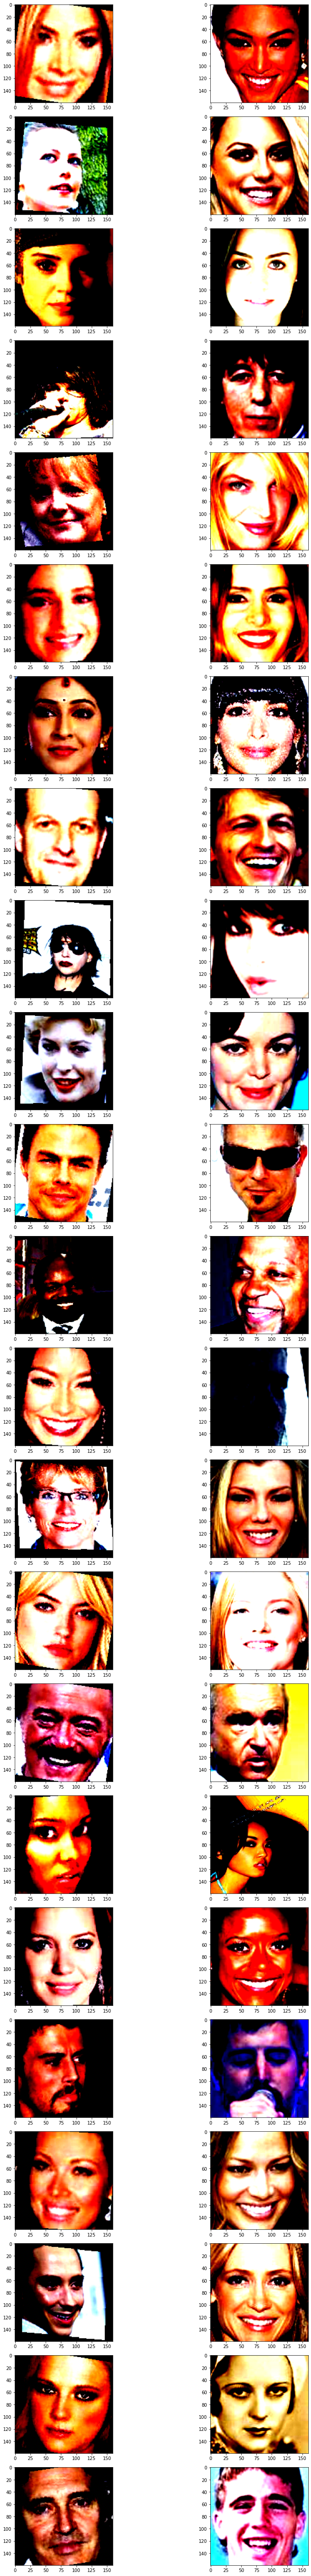

In [18]:
fig = plt.figure(figsize=(15, 80))
columns = 2
rows = 23
for i in range(1, columns*rows +1):
    img = high_similarity[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.cpu())
plt.tight_layout()
plt.show()

**Cosine similarity distribution**: calculate all the cosine similarities between images in test dataset and train dataset of the same person. This means if you have image of person #106 in test dataset, calculate all similarities between this person's embeddings from test dataset and this person's embeddings from train dataset. 

Then also do that for pairs of different people. This means if you have image of person #106 in test dataset, calculate similarities between this person's embeddings from test dataset and other people embeddings from train dataset. 

This calculation may take a long time and memory since it's a lot of pairs. You can cut the number of pairs which you calculate distances between up to 5k, as an example.

In [19]:
train_loader_emb = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
train_emb = None
train_labels = []
with torch.no_grad():
    train_class = 0
    for train_batch in tqdm(train_loader_emb):
        train_image, train_label = train_batch['image'], torch.as_tensor(train_batch['label'])
        train_vectors = img_to_vector(train_image.to(device))
        if train_emb is None:
            train_emb = train_vectors
        else:
            train_emb = torch.cat((train_emb, train_vectors))
        train_labels.append(train_label.tolist())

test_emb = None
test_labels = []
with torch.no_grad():
    train_class = 0
    for train_batch in tqdm(test_loader):
        train_image, train_label = train_batch['image'], torch.as_tensor(train_batch['label'])
        train_vectors = img_to_vector(train_image.to(device))

        if test_emb is None:
            test_emb = train_vectors
        else:
            test_emb = torch.cat((test_emb, train_vectors))
        test_labels.append(train_label.tolist())

test_emb = test_emb.squeeze().cpu()
test_labels = [c for i in test_labels for c in i]

train_emb = train_emb.squeeze().cpu()
train_labels = [c for i in train_labels for c in i]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [20]:
def sim_matrix(a, b, col, idx, eps=1e-8):
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    matrix = pd.DataFrame(data=sim_mt.transpose(0, 1).numpy(), columns=col, index=idx)
    return matrix

In [21]:
sm = sim_matrix(train_emb, test_emb, train_labels, test_labels)

<AxesSubplot:>

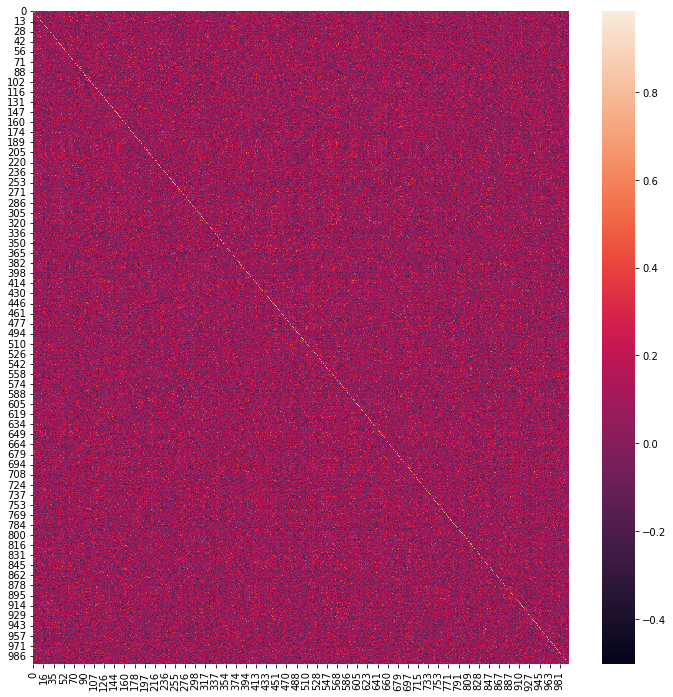

In [22]:
plt.figure(figsize=(12, 12))
sns.heatmap(sm)

## Task 2 (20% points): Identificaton rate metric (not done)

When training the model above we used CE loss on val and test set as a measure of performance of our model. But this has a major disadvantage: we can't measure how godd a model would work on unseen faces (which are not present in training, val & test sets)

To address this we can calculate another metric for the model: **identification rate**. This is how it works:

We have two sets of faces: query and distractors. None of the faces from those sets are present in train, val or test sets.

1. calculate cosine similarities between all the faces corresponding to the same people from query dataset. This means if the person has 3 photos in query part: 01.jpg, 02.jpg, 03.jpg, then calculate 3 cosine similarities between every pair of embeddings corresponding to those photos. 
2. calculate cosine similarities between all the faces corresponding to the different people from query dataset. 
3. calculate cosine similarities between all the pairs of embeddings corresponding to query and distractors. This means calculate similarities between pairs (q, d), where q is the embedding that corresponds to a face from query, d — embedding that corresponds to a face from distractors. You'll get |query|*|distractors| similarities.
4. Sum numbers of similarities from 2 and 3 stages. This is a number of false pairs.
5. fix **FPR** (false positive rate). Let it be 0.01 in our case. FPR multiplied by a number of false pairs from the stage 4 is the number of false positives we would allow our model to make. Let's call this number N
6. Sort all the similarities of false pairs by descending order. Get the Nth element from the beginning — that's our **threshold similarity**.
7. Calculate how many positive similarities from stage 1 are equal or more that threshold. Divide this number by whole number of positive similarities from stage 1. This is TPR (true positive rate) — our metric.

This metric can also be expressed as TPR@FPR=0.01. FPR can vary. 

Datasets (query photos, query labels & distructors photos) you can download from here: https://disk.yandex.ru/d/C54mClLmQkag6Q

**Task**: implement the TPR@FPR metric. Calculate it for your model and test dataset on FPR=[0.5, 0.2, 0.1, 0.05].

There're some functions pre-defined and some tests given for better understanding. Please don't change the functions prototypes, so that you can use asserts for checking.

In [23]:
# from collections import defaultdict

# # file with query part annotations: which image belongs to which class
# # format: 
# #     image_name_1.jpg 2678
# #     image_name_2.jpg 2679
# f = open('../input/celebaquery-distractors/celebA_ir/celebA_anno_query.txt', 'r')
# query_lines = f.readlines()
# f.close()
# query_lines = [x.strip().split() for x in query_lines]
# # plain list of image names from query. Neede to compute embeddings for query
# query_img_names = [x[0] for x in query_lines]

# # dictionary with info of which images from query belong to which class
# # format:
# #     {class: [image_1, image_2, ...]}
# query_dict = defaultdict(list)
# for img_name, img_class in query_lines:
#     query_dict[img_class].append(img_name)

# # list of distractor images
# distractors_img_names = os.listdir('../input/celebaquery-distractors/celebA_ir/celebA_distractors') 

In [24]:
# def compute_embeddings(model, images_list):
#   '''
#   compute embeddings from the trained model for list of images.
#   params:
#     model: trained nn model that takes images and outputs embeddings
#     images_list: list of images paths to compute embeddings for
#   output:
#     list: list of model embeddings. Each embedding corresponds to images 
#           names from images_list
#   '''
#   # YOUR CODE HERE
#   raise NotImplementedError

In [25]:
# query_embeddings = compute_embeddings(model, query_img_names)
# distractors_embeddings = compute_embeddings(model, distractors_img_names)

In [26]:
# def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
#   '''
#   compute cosine similarities between positive pairs from query (stage 1)
#   params:
#     query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in 
#                 the dataset. Value: images corresponding to that class
#     query_img_names: list of images names
#     query_embeddings: list of embeddings corresponding to query_img_names
#   output:
#     list of floats: similarities between embeddings corresponding 
#                     to the same people from query list
#   '''
#   # YOUR CODE HERE
#   raise NotImplementedError

# def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
#   '''
#   compute cosine similarities between negative pairs from query (stage 2)
#   params:
#     query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in 
#                 the dataset. Value: images corresponding to that class
#     query_img_names: list of images names
#     query_embeddings: list of embeddings corresponding to query_img_names
#   output:
#     list of floats: similarities between embeddings corresponding 
#                     to different people from query list
#   '''
#   # YOUR CODE HERE
#   raise NotImplementedError

# def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
#   '''
#   compute cosine similarities between negative pairs from query and distractors
#   (stage 3)
#   params:
#     query_embeddings: list of embeddings corresponding to query_img_names
#     distractors_embeddings: list of embeddings corresponding to distractors_img_names
#   output:
#     list of floats: similarities between pairs of people (q, d), where q is 
#                     embedding corresponding to photo from query, d —
#                     embedding corresponding to photo from distractors
#   '''
#   # YOUR CODE HERE
#   raise NotImplementedError

In [27]:
# cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names, 
#                                             query_embeddings)
# cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names, 
#                                             query_embeddings)
# cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, 
#                                                             distractors_embeddings)


Check you code of functions which compute similarities:

In [28]:
# test_query_dict = {
#     2876: ['1.jpg', '2.jpg', '3.jpg'],
#     5674: ['5.jpg'],
#     864:  ['9.jpg', '10.jpg'],
# }
# test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
# test_query_embeddings = [
#                     [1.56, 6.45,  -7.68],
#                     [-1.1 , 6.11,  -3.0],
#                     [-0.06,-0.98,-1.29],
#                     [8.56, 1.45,  1.11],
#                     [0.7,  1.1,   -7.56],
#                     [0.05, 0.9,   -2.56],
# ]

# test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

# test_distractors_embeddings = [
#                     [0.12, -3.23, -5.55],
#                     [-1,   -0.01, 1.22],
#                     [0.06, -0.23, 1.34],
#                     [-6.6, 1.45,  -1.45],
#                     [0.89,  1.98, 1.45],
# ]

# test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names, 
#                                             test_query_embeddings)
# test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names, 
#                                             test_query_embeddings)
# test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings, 
#                                                             test_distractors_embeddings)

In [29]:
# true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
#                          -0.18355866977496182, 0.9787437979250561]
# assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
#       "A mistake in compute_cosine_query_pos function"

# true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
#                          -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
#                          -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
#                          -0.011982733001947084, -0.0466679194884999]
# assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)) \
#       "A mistake in compute_cosine_query_neg function"

# true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
#                                  0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
#                                  -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
#                                  0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
#                                  -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
#                                  -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
#                                  -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
#                                  -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
#                                  -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
#                                  -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
# assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
#       "A mistake in compute_cosine_query_distractors function"

Implement the final function: identification rate calculation

In [30]:
# def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, 
#                fpr=0.1):
#   '''
#   compute identification rate using precomputer cosine similarities between pairs
#   at given fpr
#   params:
#     cosine_query_pos: cosine similarities between positive pairs from query
#     cosine_query_neg: cosine similarities between negative pairs from query
#     cosine_query_distractors: cosine similarities between negative pairs 
#                               from query and distractors
#     fpr: false positive rate at which to compute TPR
#   output: 
#     float: threshold for given fpr 
#     float: TPR at given FPR
#   '''
#   # YOUR CODE HERE
#   pass

Check yourself:

In [31]:
# test_thr = []
# test_tpr = []
# for fpr in [0.5, 0.3, 0.1]:
#   x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg, 
#                     test_cosine_query_distractors, fpr=fpr)
#   thr.append(x)
#   tpr.append(y)

In [32]:
# true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
# assert np.allclose(np.array(thr), np.array(true_thr)), "A mistake in computing threshold"

# true_tpr = [0.75, 0.5, 0.5]
# assert np.allclose(np.array(tpr), np.array(true_tpr)), "A mistake in computing tpr"

Finally compute tpr for faces query and distractors dataset and fpr = [0.5, 0.2, 0.1, 0.05]:

## Task 3 (50% points): Loss functions

Building a network on task 1 we used an ordinary CE loss. But there are many more variants of loss functions that can be used to train neural network. We will discuss two of them, which are the most popular. More examples of losses for face recognition and their performance reviews you can find in this paper: https://arxiv.org/pdf/1901.05903.pdf

### TripletLoss (25% points)

This is another kind of loss which does not require a model to have last classification layer — it works directly with embeddings. It requires by design to make embeddings of one person be close on embeddings space and embeddings of different people be far away from each other. 

This loss has an advantage over CE-like losses: it does not rely on number of classes in dataset. If we have new faces of new people in a dataset, we won't need to completely retrain the network, we could just fine-tune the trained network on new photos.


**How TripletLoss works**:

Here the architecture of neural network will be slightly different than it was when we used CE loss: it won't have the last classification layer. The last layer of NN will output embeddings of the given photo. 

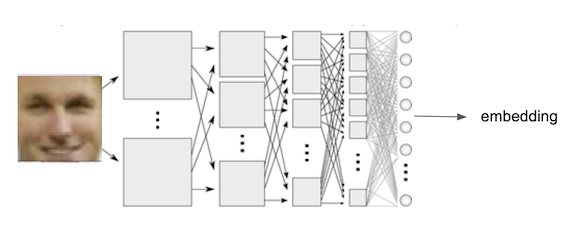

The TripletLoss function works directly with these embeddings. The idea of it is to make embeddings of the same people more close, compact in the embedding space, and the embeddings of the different people be more separate. There's a formula for the loss:

$$L(e, p, n) = max\{d(a, p) - d(a, n) + margin, 0\},$$

where 
- $e$ is embedding of a photo (output of a model)
- $p$ is a positive embedding for the photo (embedding that we want $e$ be close to)
- $n$ is a negative embedding for the photo (embedding that we want $e$ be far from)
- $d(x, y)$ is a distance measure between embeddings 
- margin — a positive margin to further boost the difference between $d(a, p)$ and $d(a, n)$

**All the embeddings $e$, $p$ and $n$ must be normalized before passing them to the loss**.

In our case for the given photo $E$ and it's embedding $e$ positive embedding $p$ must be an embedding of the photo of the same person and embedding $n$ must be an ambedding of the photo of the different person.

This emplementation of TripletLoss for PyTorch can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss). There are different variants of TripletLoss which can also boost performance and which you can implement by yourself, if you want:
- use more that 1 sample of $p$ and $n$ for one embedding $e$ 
- use special kinds of negatives: e.g. the negatives that are the most close to e (to boost them be further away from e)


**More to read about TripletLoss**:

The idea of TripletLoss: https://en.wikipedia.org/wiki/Triplet_loss

PyTorch implementation of TripletLoss: https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss

**Task**: implement a model and train it with TripletLoss. Play with margin parameter to achieve better results.

Which loss among which you have tried is the best?

**To get the full mark for this task you need to train a model using  TripletLoss correctly at least for one value of margin and achieve >=75% acc on test set.** 
As we don't have a classification layer in our network, we need a custom procedure for accuracy calculation. You can use one of the following procedures:
- calculate accuracy on val and test sets using KNN with embeddings from training set as training points. (easy way)
- compute mean embeddings for every class from training set and use them as reference embeddings. Then for every embedding v from val and test sets calculate cosine similarities between v and mean embeddings from train set. (the more "right" way, but requires code writing)

You can use any of those two variants.

**Hints**:
- think of what the distance function $d$ should be in our case: training a model we want it to output embeddings which can be compared using cosine similarity function. Pay attention to that cosine similarity is not a distance measure — the more cosine distance, the closer embeddings are. Think how you can put cosine distance into TripletLoss function.
- to train model using this loss you'll need to rewrite the Dataset class so it gives you not the random image and its label, but the image, positive images and negative images for this image;
- don't forget to normalize embeddings for the loss! You may even do that by adding batchnorm/layernorm to the last layer of your network

In [33]:
class Triplet_celebADataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, dataset_type, transform, aug=None,):
        self.images = get_paths(dataset_type=dataset_type)

        f = open('../input/celeba-1k-classes/celebA_train_1k/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:y for x, y in labels}
        self.labels = [int(labels[x.split('/')[-1]]) for x in self.images]
        self.transform = transform
        self.aug = aug
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        classes = np.arange(len(self.labels)-1)
        positive_class, negative_class = np.random.choice(classes, size=2)

        anchor_img = self.images[positive_class]
        anchor_label = self.labels[positive_class]
        
        pos_label = self.labels[positive_class+1]
        if pos_label != anchor_label:
            pos_img = self.images[positive_class-1]
            pos_label = self.labels[positive_class-1]
        else:
            pos_img = self.images[positive_class+1]
        
        neg_img = self.images[negative_class]
        neg_label = self.labels[negative_class]
        
        image_anchor = Image.open(anchor_img)
        image_neg = Image.open(neg_img)
        image_pos = Image.open(pos_img)
        
        face_anchor = detectFace(image_anchor)
        face_neg = detectFace(image_neg)
        face_pos = detectFace(image_pos)
        
        sample = {
            'anchor': self.transform(face_anchor),
            'anchor_label': anchor_label,
            
            'positive': self.transform(face_pos),
            'positive_label': pos_label,
            
            'negative': self.transform(face_neg),
            'negative_label': neg_label,
        }
        
        return sample

In [34]:
def train_triplet(model, optimizer, criterion, n_epochs, train_loader, val_loader):
    valid_loss_min = np.Inf # track change in validation loss
    for epoch in range(1, n_epochs+1):
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        model.train()
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            anchor, anchor_label, pos_img, pos_label, neg_img, neg_label = \
                    batch['anchor'], batch['anchor_label'], batch['positive'], batch['positive_label'], batch['negative'], batch['negative_label']

            anchor = model(anchor.to(device))
            positive = model(pos_img.to(device))
            negative = model(neg_img.to(device))

            loss = criterion(anchor, positive, negative)
            loss.backward()

            optimizer.step()
            train_loss += loss.item()*anchor.size(0)

        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_loader):
                anchor, anchor_label, pos_img, pos_label, neg_img, neg_label = \
                    batch['anchor'], batch['anchor_label'], batch['positive'], batch['positive_label'], batch['negative'], batch['negative_label']

                anchor = model(anchor.to(device))
                positive = model(pos_img.to(device))
                negative = model(neg_img.to(device))
                loss = criterion(anchor, positive, negative)
                valid_loss += loss.item()*anchor.size(0)

        # calculate average losses
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(val_loader.sampler)
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(embedding.state_dict(), 'model_best_weights.pt')
            valid_loss_min = valid_loss

In [35]:
triplet_train_data = Triplet_celebADataset('train', transform_train)
triplet_val_data = Triplet_celebADataset('val', transform_test)
triplet_test_data = Triplet_celebADataset('test', transform_test)

triplet_train_loader = torch.utils.data.DataLoader(triplet_train_data, batch_size=batch_size, shuffle=False)
triplet_val_loader = torch.utils.data.DataLoader(triplet_val_data, batch_size=batch_size, shuffle=False)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_data, batch_size=batch_size, shuffle=False)

In [36]:
# add batchnorm as last layer of model
embedding = nn.Sequential(InceptionResnetV1(pretrained='vggface2', classify=False), nn.BatchNorm1d(512)).to(device)

In [37]:
for param in embedding[0].parameters():
    param.requires_grad = False

for param in embedding[0].logits.parameters():
    param.requires_grad = True

for param in embedding[0].last_bn.parameters():
    param.requires_grad = True

for param in embedding[0].last_linear.parameters():
    param.requires_grad = True

for param in embedding[0].block8.parameters():
    param.requires_grad = True

for param in embedding[1].parameters():
    param.requires_grad = True

# check which layers requires_grad
for name, param in embedding.named_parameters():
    if param.requires_grad:
        print(name)

0.block8.branch0.conv.weight
0.block8.branch0.bn.weight
0.block8.branch0.bn.bias
0.block8.branch1.0.conv.weight
0.block8.branch1.0.bn.weight
0.block8.branch1.0.bn.bias
0.block8.branch1.1.conv.weight
0.block8.branch1.1.bn.weight
0.block8.branch1.1.bn.bias
0.block8.branch1.2.conv.weight
0.block8.branch1.2.bn.weight
0.block8.branch1.2.bn.bias
0.block8.conv2d.weight
0.block8.conv2d.bias
0.last_linear.weight
0.last_bn.weight
0.last_bn.bias
0.logits.weight
0.logits.bias
1.weight
1.bias


In [38]:
lr = 1e-4
# criterion = nn.TripletMarginWithDistanceLoss(distance_function=nn.PairwiseDistance())
# criterion = nn.TripletMarginWithDistanceLoss(distance_function=nn.CosineSimilarity())

criterion = nn.TripletMarginLoss(margin=0.2, p=2)
# criterion = \
#     nn.TripletMarginWithDistanceLoss(
#     distance_function=lambda x, y: 1.0 - F.cosine_similarity(x, y))

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, embedding.parameters()),
    lr=lr)

n_epochs = 5

train_triplet(embedding, optimizer, criterion, n_epochs, triplet_train_loader, triplet_val_loader)

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.040040 	Validation Loss: 0.053797
Validation loss decreased (inf --> 0.053797).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.034956 	Validation Loss: 0.059025


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.028582 	Validation Loss: 0.049900
Validation loss decreased (0.053797 --> 0.049900).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.024259 	Validation Loss: 0.065394


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.026100 	Validation Loss: 0.047649
Validation loss decreased (0.049900 --> 0.047649).  Saving model ...


In [39]:
embedding.load_state_dict(torch.load('./model_best_weights.pt'))

<All keys matched successfully>

### Testing accuracy of triplet model

calculate accuracy with faiss

In [40]:
faiss_index = faiss.IndexFlatL2(512) # build the index
im_labels = []
embedding.eval()
with torch.no_grad():
    for batch in tqdm(train_loader):
        image, label = batch['image'].to(device), batch['label']
        preds = embedding(image)
        preds = preds.cpu().numpy()
        faiss_index.add(preds) # add the representation to index
        im_labels.append(label)   # store the image name to find it later on

im_labels = [k.item() for i in im_labels for k in i]

# calculate accuracy with faiss
true_labels = 0
embedding.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        image, label = batch['image'].to(device), batch['label']
    
        test_embed = embedding(image)
        test_embed = test_embed.cpu().numpy()
        _, I = faiss_index.search(test_embed, 1)
        true_labels += (label.numpy() == np.array([im_labels[i[0]] for i in I])).sum()

accuracy = true_labels * 100 / len(test_data)

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [41]:
print("model accuracy with Triplet Loss: {:.2f}%".format(accuracy.item()))

model accuracy with Triplet Loss: 88.66%


In [42]:
# from sklearn.neighbors import KNeighborsClassifier
# k_neighbors = KNeighborsClassifier(n_neighbors=1,n_jobs=-1)

# train_labels = []
# train_embedding = []

# embedding.eval()
# with torch.no_grad():
#     for batch in tqdm(train_data):
#         image, label = batch['image'].to(device), batch['label']
#         preds = embedding(image.unsqueeze(0))
#         preds = preds.cpu().numpy().flatten()
#         train_embedding.append(preds)
#         train_labels.append(label)   #store the image name to find it later on

# train_embedding = np.array(train_embedding)

# test_labels = []
# test_embedding = []
# embedding.eval()
# with torch.no_grad():
#     for batch in tqdm(test_data):
#         image, label = batch['image'], batch['label']
    
#         test_embed = embedding(image.unsqueeze(0).to(device))
#         test_embed = test_embed.cpu().numpy().flatten()
#         test_labels.append(label)
#         test_embedding.append(test_embed)
        
# test_embedding = np.array(test_embedding)
# k_neighbors.fit(train_embedding, train_labels)

# # calculating accuracy with knn
# acc = k_neighbors.score(np.array(test_embedding), test_labels)
# print("model accuracy: {:.2f}%".format(acc * 100))

calculate accuracy with cosine similarity

In [43]:
def sim_matrix(a, b, eps=1e-8):
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt.cpu().numpy()

In [44]:
# create embedding of train dataset

train_labels = []
train_embedding = []

embedding.eval()
with torch.no_grad():
    for batch in tqdm(train_loader):
        image, label = batch['image'].to(device), batch['label']
        img_emb = embedding(image)
        train_embedding.append(img_emb)
        train_labels.append(label)   #store the image name to find it later on

train_labels = [k.item() for i in train_labels for k in i]
train_embedding = [k for i in train_embedding for k in i]
train_embedding = torch.stack((train_embedding))

  0%|          | 0/267 [00:00<?, ?it/s]

In [45]:
correct_labels = 0
embedding.eval()
with torch.no_grad():
    for batch in tqdm(test_data):
        image, true_label = batch['image'].to(device), batch['label']
        img_emb = embedding(image.unsqueeze(0))
        similarities = sim_matrix(img_emb, train_embedding)
        pred_label = train_labels[similarities.argmax()]
        correct_labels += (np.array(pred_label) == np.array(true_label)).sum()

accuracy = correct_labels * 100 / len(test_data)

  0%|          | 0/3174 [00:00<?, ?it/s]

In [46]:
print("model accuracy with Triplet Loss: {:.2f}%".format(accuracy.item()))

model accuracy with Triplet Loss: 88.88%


In [47]:
results = results.append({'loss': 'TripletLoss', 'accuracy': accuracy.item()}, ignore_index=True)

**CrossEntropy + TripletLoss**

In [48]:
# model_double_loss = InceptionResnetV1(pretrained='vggface2', num_classes=1000, classify=True).to(device)
# # freeze all layers except the last
# for param in model_double_loss.parameters():
#     param.requires_grad = False

# for param in model_double_loss.logits.parameters():
#     param.requires_grad = True

# for param in model_double_loss.last_bn.parameters():
#     param.requires_grad = True

# for param in model_double_loss.last_linear.parameters():
#     param.requires_grad = True

# for param in model_double_loss.block8.parameters():
#     param.requires_grad = True

# # check which layers requires_grad
# for name, param in model_double_loss.named_parameters():
#     if param.requires_grad:
#         print(name)

# activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook

# def train_double_loss(model, optimizer, criterion, criterion_triplet, n_epochs, train_loader, val_loader, triplet_train_loader, triplet_val_loader):
#     valid_loss_min = np.Inf # track change in validation loss
#     for epoch in range(1, n_epochs+1):
#         # keep track of training and validation loss
#         train_loss = 0.0
#         valid_loss = 0.0
#         model.train()
#         for batch, triplet_batch in tqdm(zip(train_loader, triplet_train_loader)):
#             optimizer.zero_grad()
            
#             image, label = batch['image'].to(device), torch.as_tensor(batch['label']).to(device)
#             output = model(image)
            
#             anchor, anchor_label, pos_img, pos_label, neg_img, neg_label = \
#                         triplet_batch['anchor'], triplet_batch['anchor_label'], triplet_batch['positive'], triplet_batch['positive_label'],triplet_batch['negative'], triplet_batch['negative_label']
            
#             anchor = model(anchor.to(device))
#             anchor = activation['last_linear']

#             positive = model(pos_img.to(device))
#             positive = activation['last_linear']

#             negative = model(neg_img.to(device))
#             negative = activation['last_linear']

#             loss = criterion(output, label) + criterion_triplet(anchor, positive, negative)
            
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()*image.size(0)
    
#         model.eval()
#         with torch.no_grad():
#             for batch, triplet_batch in tqdm(zip(val_loader, triplet_val_loader)):
            
#                 image, label = batch['image'].to(device), torch.as_tensor(batch['label']).to(device)
#                 output = model(image)

#                 anchor, anchor_label, pos_img, pos_label, neg_img, neg_label = \
#                             triplet_batch['anchor'], triplet_batch['anchor_label'], triplet_batch['positive'], triplet_batch['positive_label'],triplet_batch['negative'], triplet_batch['negative_label']

#                 anchor = model(anchor.to(device))
#                 anchor = activation['last_linear']

#                 positive = model(pos_img.to(device))
#                 positive = activation['last_linear']

#                 negative = model(neg_img.to(device))
#                 negative = activation['last_linear']

#                 loss = criterion(output, label) + criterion_triplet(anchor, positive, negative)
#                 valid_loss += loss.item()*image.size(0)

#         # calculate average losses
#         train_loss = train_loss/len(train_loader.sampler)
#         valid_loss = valid_loss/len(val_loader.sampler)
#         print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
#             epoch, train_loss, valid_loss))

#         # save model if validation loss has decreased
#         if valid_loss <= valid_loss_min:
#             print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
#             valid_loss_min,
#             valid_loss))
#             torch.save(model.state_dict(), 'model_best_weights.pt')
#             valid_loss_min = valid_loss
            
# lr = 1e-4
# criterion_triple = nn.TripletMarginLoss(margin=10, p=2)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(
#     filter(lambda p: p.requires_grad, model_double_loss.parameters()),
#     lr=lr)

# model_double_loss.last_linear.register_forward_hook(get_activation('last_linear'))

# n_epochs = 10

# train_double_loss(model_double_loss, optimizer, criterion, criterion_triple, n_epochs, train_loader, val_loader, triplet_train_loader, triplet_val_loader)

In [49]:
# # load best weights
# model_double_loss.load_state_dict(torch.load("./model_best_weights.pt"))
# # calculate model accuracy
# correct = 0
# total = 0
# model_double_loss.eval()

# with torch.no_grad():
#     for batch in tqdm(test_loader):
#         images, labels = batch['image'].to(device), torch.as_tensor(batch['label']).to(device)
#         outputs = model_double_loss(images)
#         outputs = torch.sigmoid(outputs)
#         predicted = torch.argmax(outputs, 1)
#         correct += (predicted == labels).sum()
#         total += len(labels)
# accuracy = 100 * correct / total
# accuracy

In [50]:
# results = results.append({'loss': 'CE + TripleLoss', 'accuracy': accuracy.item()}, ignore_index=True)

### ArcFace Loss (Additive Angular Margin Loss) (25% points)

This loss is somewhat "SOTA" for face recognition systems (somewhat — because actually different variants of losses and their combinations may be the best for different network architectures). This loss inherits idea from CE loss but further develops it to achieve better embeddings distribution on a sphere. It introduces some geodesic constraints to enhance intra-class compactness and inter-class discrepancy.



**How ArcFace loss works**:

This loss is a variation of a standard SoftMax CE loss, which enforces embeddings of different classes (people) be further away: have a more sparse representation of embeddings in embedding space, enforce more evident gap between the nearest classes.

The standard SoftMax CE loss for classification task is presented as follows:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

where:
- $x_i \in \mathbb{R^d}$ denotes the deep feature of the $i$-th sample, belonging to the $y_i$-th class;
- $W_j \in \mathbb{R^d}$ denotes the j-th column of the weight;
- $W \in \mathbb{R^d}$ and $b_j \in \mathbb{R^d}$ is the bias term;
- $N$ — batch size;
- $n$ — class number.

It appears, that, though this loss works well, it does not explicitly optimise the feature embedding to enforce higher similarity for intra- class samples and diversity for inter-class samples, which results in a performance gap for deep face recognition under large intra-class appearance variations.

Let's do some work on this loss formula:
- fix the bias $b_j=0$;
- normalize weight ||$W_j$|| = 1;
- normalize embedding ||$x_i$|| = 1 and re-scale it to s (s is a hyperparameter)

The normalisation step on embeddings and weights makes the predictions only depend on the angle between the embedding and the weight. The learned embeddings fare thus distributed on a hypersphere with a radius of s.

So we get the following loss function now:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Final step: let's add an additive angular margin penalty $m$ between $x_i$ and $W_{y_i}$ to simultaneously enhance the intra-class compactness and inter-class discrepancy:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

SO this is an ArcFace loss. It has 2 hyperparameters: s and m.

The original paper to read about ArcFace more precisely: https://arxiv.org/pdf/1801.07698.pdf

The original repo, where you can find a code sample: https://github.com/deepinsight/insightface

**Task**: implement a model and train it with ArcFace loss. Play with ArcFace loss parameters and see if you can beat a model with CE loss.

To get the full mark for this task you need to train a model using TripletLoss correctly at least for one value of margin and achieve >=75% acc on test set.

In [51]:
class ArcFace(nn.Module):
    def __init__(self, in_features, out_features, s=64.0, m=0.5, easy_margin=False, ls_eps=0.0):
        super(ArcFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps  # label smoothing
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device=device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) ------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

In [52]:
class ArcFace_model(nn.Module):
    def __init__(self):
        super(ArcFace_model, self).__init__()
        
        self.encoding = InceptionResnetV1(pretrained='vggface2', num_classes=1000, classify=False)
        self.bn1 = nn.BatchNorm1d(512)
        self.arcface = ArcFace(512, 1000)

    def forward(self, x, labels=None):
        x = self.encoding(x)
        x = self.bn1(x)
        if labels is not None:
            x = self.arcface(x, labels)
        return x

arcface_model = ArcFace_model().to(device)

# freeze all layers except the last
for param in arcface_model.parameters():
    param.requires_grad = False

for param in arcface_model.encoding.logits.parameters():
    param.requires_grad = True

for param in arcface_model.encoding.last_bn.parameters():
    param.requires_grad = True

for param in arcface_model.encoding.last_linear.parameters():
    param.requires_grad = True

for param in arcface_model.encoding.block8.parameters():
    param.requires_grad = True

for param in arcface_model.arcface.parameters():
    param.requires_grad = True
    
# for param in embedding[0].mixed_7a.parameters():
#     param.requires_grad = True

# check which layers requires_grad
for name, param in arcface_model.named_parameters():
    if param.requires_grad:
        print(name)

encoding.block8.branch0.conv.weight
encoding.block8.branch0.bn.weight
encoding.block8.branch0.bn.bias
encoding.block8.branch1.0.conv.weight
encoding.block8.branch1.0.bn.weight
encoding.block8.branch1.0.bn.bias
encoding.block8.branch1.1.conv.weight
encoding.block8.branch1.1.bn.weight
encoding.block8.branch1.1.bn.bias
encoding.block8.branch1.2.conv.weight
encoding.block8.branch1.2.bn.weight
encoding.block8.branch1.2.bn.bias
encoding.block8.conv2d.weight
encoding.block8.conv2d.bias
encoding.last_linear.weight
encoding.last_bn.weight
encoding.last_bn.bias
encoding.logits.weight
encoding.logits.bias
arcface.weight


In [53]:
def train(model, optimizer, criterion, n_epochs, train_loader, val_loader):
    valid_loss_min = np.Inf # track change in validation loss
    for epoch in range(1, n_epochs+1):
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        model.train()
        for batch in tqdm(train_loader):
            image, label = batch['image'].to(device), torch.as_tensor(batch['label']).to(device)
            optimizer.zero_grad()
            output = model(image, label)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*image.size(0)

        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_loader):
                image, label = batch['image'].to(device), torch.as_tensor(batch['label']).to(device)
                output = model(image, label)
                loss = criterion(output, label)
                valid_loss += loss.item()*image.size(0)

        # calculate average losses
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(val_loader.sampler)
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_best_weights.pt')
            valid_loss_min = valid_loss

In [54]:
lr = 1e-4
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, arcface_model.parameters()),
    lr=lr)
criterion = nn.CrossEntropyLoss()
n_epochs = 5

train(arcface_model, optimizer, criterion, n_epochs, train_loader, val_loader)

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 36.625088 	Validation Loss: 32.679601
Validation loss decreased (inf --> 32.679601).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 31.372575 	Validation Loss: 29.135808
Validation loss decreased (32.679601 --> 29.135808).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 28.372440 	Validation Loss: 26.467325
Validation loss decreased (29.135808 --> 26.467325).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 25.902466 	Validation Loss: 24.289603
Validation loss decreased (26.467325 --> 24.289603).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 23.583992 	Validation Loss: 22.029882
Validation loss decreased (24.289603 --> 22.029882).  Saving model ...


In [55]:
arcface_model.load_state_dict(torch.load('./model_best_weights.pt'))

<All keys matched successfully>

In [56]:
# create embedding of train dataset

train_labels = []
train_embedding = []

arcface_model.eval()
with torch.no_grad():
    for batch in tqdm(train_loader):
        image, label = batch['image'].to(device), batch['label']
        img_emb = arcface_model(image)
        train_embedding.append(img_emb)
        train_labels.append(label)   

train_labels = [k.item() for i in train_labels for k in i]
train_embedding = [k for i in train_embedding for k in i]
train_embedding = torch.stack((train_embedding))

  0%|          | 0/267 [00:00<?, ?it/s]

In [57]:
correct_labels = 0
arcface_model.eval()
with torch.no_grad():
    for batch in tqdm(test_data):
        image, true_label = batch['image'].to(device), batch['label']
        img_emb = arcface_model(image.unsqueeze(0))
        similarities = sim_matrix(img_emb, train_embedding)
        pred_label = train_labels[similarities.argmax()]
        correct_labels += (np.array(pred_label) == np.array(true_label)).sum()

accuracy = correct_labels * 100 / len(test_data)

print("model accuracy with ArcFace Loss: {:.2f}%".format(accuracy.item()))

  0%|          | 0/3174 [00:00<?, ?it/s]

model accuracy with ArcFace Loss: 92.00%


In [58]:
results = results.append({'loss': 'ArcFace', 'accuracy': accuracy.item()}, ignore_index=True)

In [59]:
results

loss   accuracy
0  CrossEntropy  91.241333
1   TripletLoss  88.878387
2       ArcFace  91.997480

## Bonus task (5% points): Finding trash photos (not done)

You have probably noticed that in identification rate calculation we use cosine similarity between embeddings, which includes embeddings' normalization. And in TripletLoss also we normalize embeddings before passing them to the loss. Actually this is how most of the face recognition algorithms work — they are designed to output a normalized embeddings and any comparison between embeddings is done after the embeddings are normalized. Sometimes it may be beneficial even to add a normalization layer (batchnorm or layernorm with fixed parameters) after the model's embedding layer to make the model output normalized embeddings.

But norms of the unnormalized embeddings can also be used. They can be used to detect trash photos — photos, where the face is presented really badly (e.g. back of the head instead of the forehead or even a photo without any head that has appeared in a dataset due to a mistake in face detection / landmarks detection algorithm).

Empirically it has been found that the higher the embedding's norm, the more the probability of the corresponding photo to be trash is. 



**Task**: get the embeddings of photos in a test set / query set / distractors set. Sort them by their norms. Output the photos whose embeddings norms are the highest. Do they look like normal or trash?

**Doing this task will not give you points above 100% for the whole homework. But if you have any mistakes in previous sections, doing this task may give you additional points (5% of total points) to cover points lost.**

In [60]:
# YOUR CODE HERE

## What's next

What else can you do with this homework:
1. Try to train the network on faces which are aligned differently (or not aligned at all). The dataset can be downloaded here[link text](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ)
2. Try to mix different losses while training. This often helps.
3. Try other losses from [this](https://arxiv.org/pdf/1901.05903.pdf) paper
4. Train bigger model on bigger dataset, as whole celebA, add [LFW](http://vis-www.cs.umass.edu/lfw/) and other
5. Explore embeddings spaces you get out of different models. How well are embeddings clasterized? Are they evenly spreaded on the sphere? How could you suggest to make it better?